In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
import os
import pandas as pd

data_path = r"C:\Users\annis\Documents\SMT 6\komvis\project-uas\train"

images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.shape

(25848, 2)

In [4]:
# Split data into train, validation and test sets
strat = data['label']
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, random_state=123, stratify=strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

In [ ]:
img_size = (299, 299) 
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    rescale=1./255
)

# Validation and test data generator (only rescaling)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 20678 validated image filenames belonging to 11 classes.
Found 2585 validated image filenames belonging to 11 classes.
Found 2585 validated image filenames belonging to 11 classes.


In [6]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [7]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)

In [9]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.70195, saving model to best_model.keras
646/646 ━━━━━━━━━━━━━━━━━━━━ 1560s 2s/step - accuracy: 0.4338 - loss: 1.6850 - val_accuracy: 0.7020 - val_loss: 0.8565 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.70195
646/646 ━━━━━━━━━━━━━━━━━━━━ 153s 235ms/step - accuracy: 0.7188 - loss: 0.9498 - val_accuracy: 0.7012 - val_loss: 0.8622 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_accuracy improved from 0.70195 to 0.73906, saving model to best_model.keras
646/646 ━━━━━━━━━━━━━━━━━━━━ 1545s 2s/step - accuracy: 0.6775 - loss: 0.9353 - val_accuracy: 0.7391 - val_loss: 0.7308 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.73906
646/646 ━━━━━━━━━━━━━━━━━━━━ 154s 236ms/step - accuracy: 0.6250 - loss: 1.0744 - val_accuracy: 0.7383 - val_loss: 0.7373 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_accuracy improved from 0.73906 to 0.76992, saving model to best_model.kera

In [12]:
# Load the best model
model.load_weights('best_model.keras')

In [13]:
# simpan model yang sudah pakai bobot terbaik
model.save('model_inceptionv3_best.h5')

In [14]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

81/81 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7807 - loss: 0.5918
Test Accuracy: 0.7861
Test Loss: 0.5789


In [15]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Subplot untuk Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Menambahkan angka pada setiap titik di garis Accuracy
    for i in range(len(history.history['accuracy'])):
        plt.annotate(f'{history.history["accuracy"][i]:.2f}', 
                     (i, history.history['accuracy'][i]), 
                     textcoords="offset points", 
                     xytext=(0,5), ha='center', color='blue')
        plt.annotate(f'{history.history["val_accuracy"][i]:.2f}', 
                     (i, history.history['val_accuracy'][i]), 
                     textcoords="offset points", 
                     xytext=(0,5), ha='center', color='orange')
    
    # Subplot untuk Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Menambahkan angka pada setiap titik di garis Loss
    for i in range(len(history.history['loss'])):
        plt.annotate(f'{history.history["loss"][i]:.2f}', 
                     (i, history.history['loss'][i]), 
                     textcoords="offset points", 
                     xytext=(0,5), ha='center', color='blue')
        plt.annotate(f'{history.history["val_loss"][i]:.2f}', 
                     (i, history.history['val_loss'][i]), 
                     textcoords="offset points", 
                     xytext=(0,5), ha='center', color='orange')
    
    plt.show()

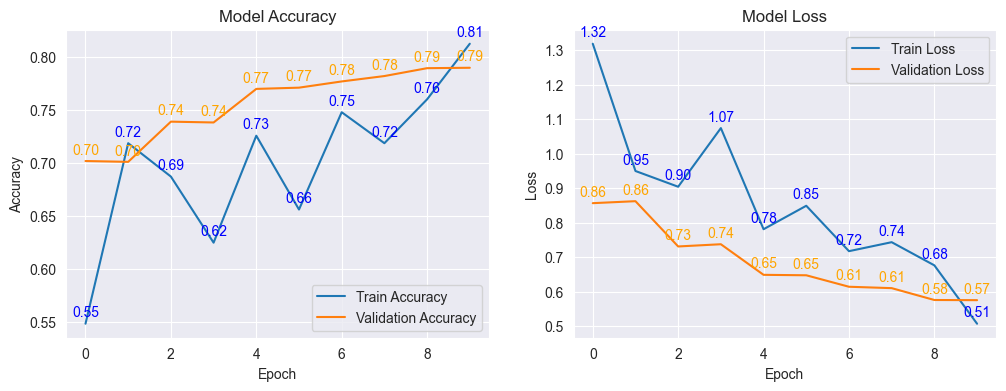

In [16]:
plot_history(history)

In [17]:
# Generate predictions
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

81/81 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step


In [18]:
# Classification report
class_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.70      0.81      0.75       282
                        Early_blight       0.85      0.60      0.70       246
                         Late_blight       0.70      0.86      0.77       311
                           Leaf_Mold       0.80      0.80      0.80       276
                  Septoria_leaf_spot       0.74      0.65      0.69       288
Spider_mites Two-spotted_spider_mite       0.79      0.79      0.79       174
                         Target_Spot       0.58      0.80      0.67       183
       Tomato_Yellow_Leaf_Curl_Virus       0.98      0.91      0.94       204
                 Tomato_mosaic_virus       0.95      0.88      0.91       216
                             healthy       0.92      0.82      0.86       305
                      powdery_mildew       0.81      0.70      0.75       100

                            accuracy                          

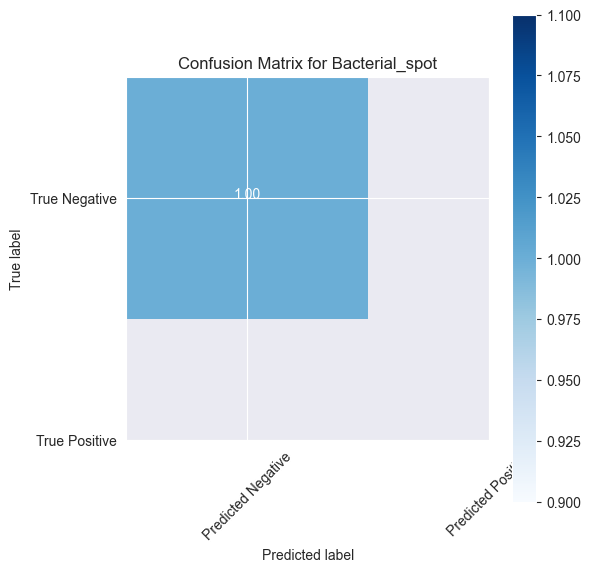

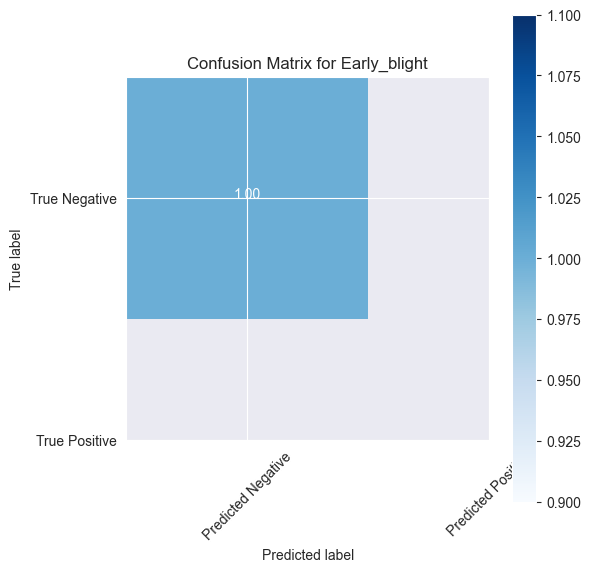

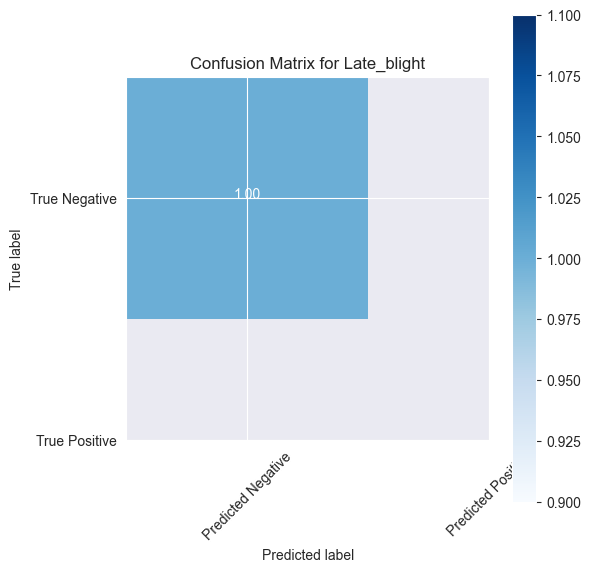

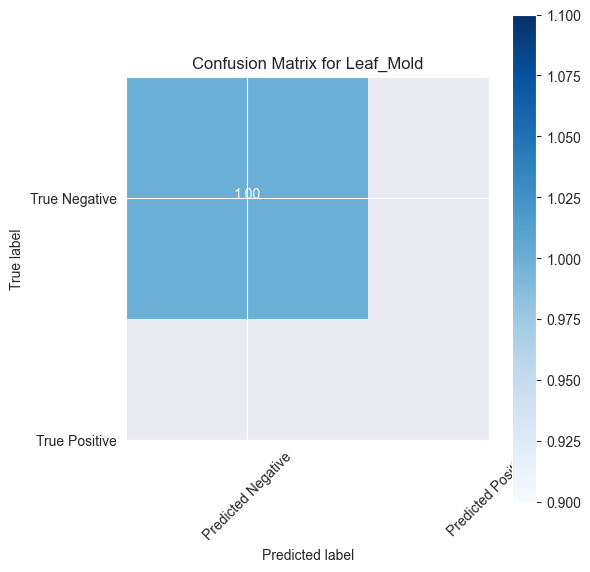

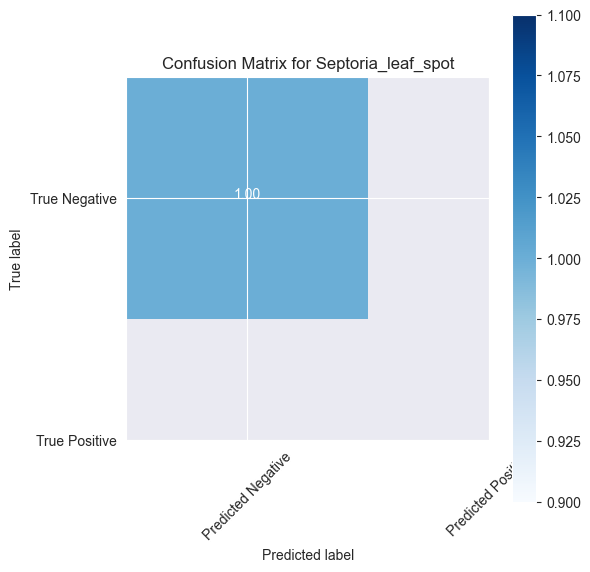

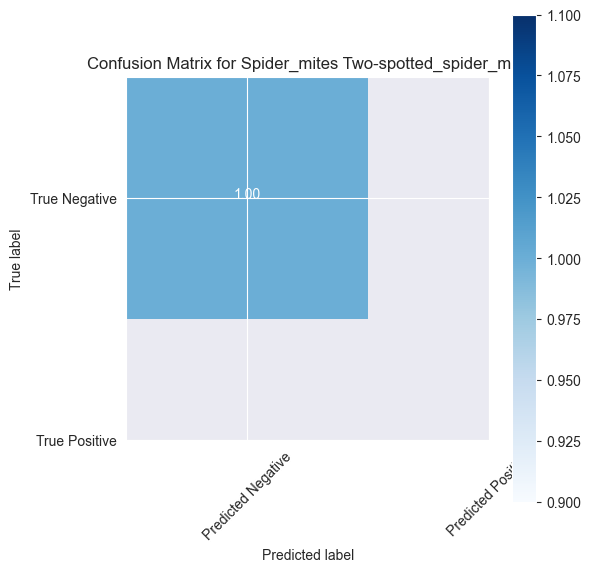

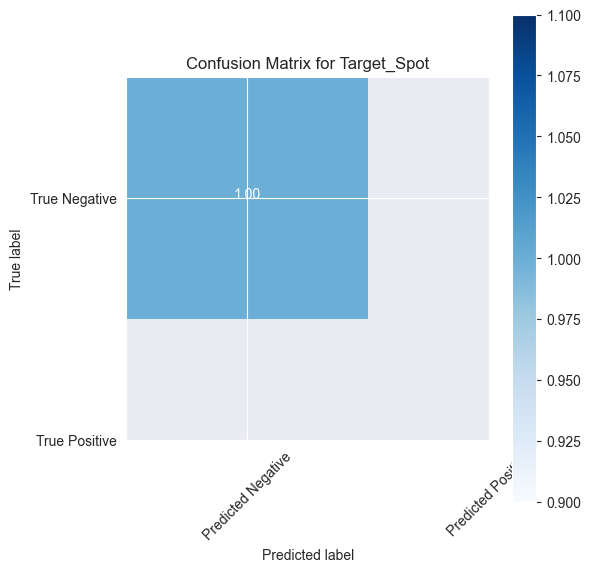

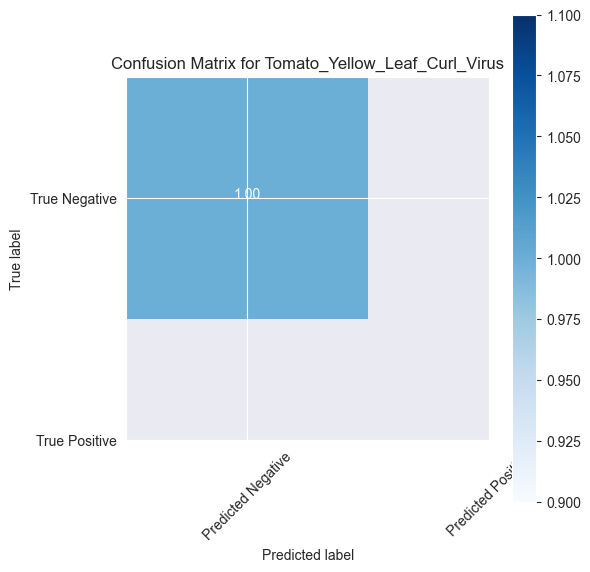

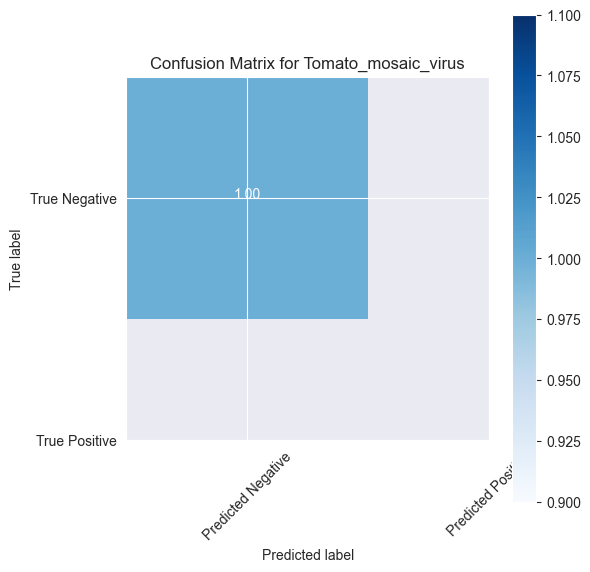

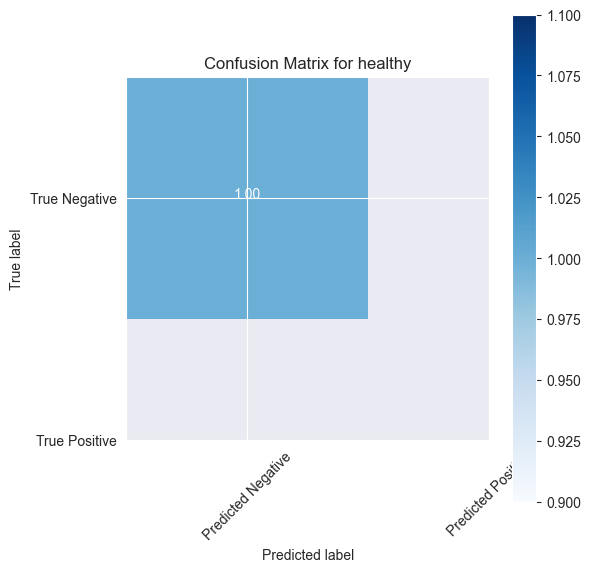

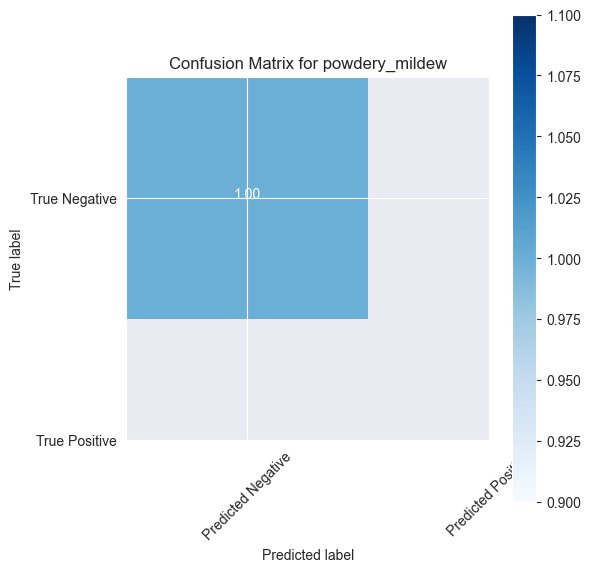

In [19]:
# Fungsi untuk menampilkan confusion matrix per kelas
def plot_confusion_matrix_per_class(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    for class_name in classes:
        # Menghasilkan binary confusion matrix untuk setiap kelas
        cm = confusion_matrix([1 if label == class_name else 0 for label in y_true],
                              [1 if label == class_name else 0 for label in y_pred])
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Membuat plot untuk confusion matrix per kelas
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(f'Confusion Matrix for {class_name}')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'], rotation=45)
        plt.yticks(tick_marks, ['True Negative', 'True Positive'])

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

# Menggunakan fungsi ini dengan dataset
plot_confusion_matrix_per_class(y_true, y_pred_classes, class_names, normalize=True)

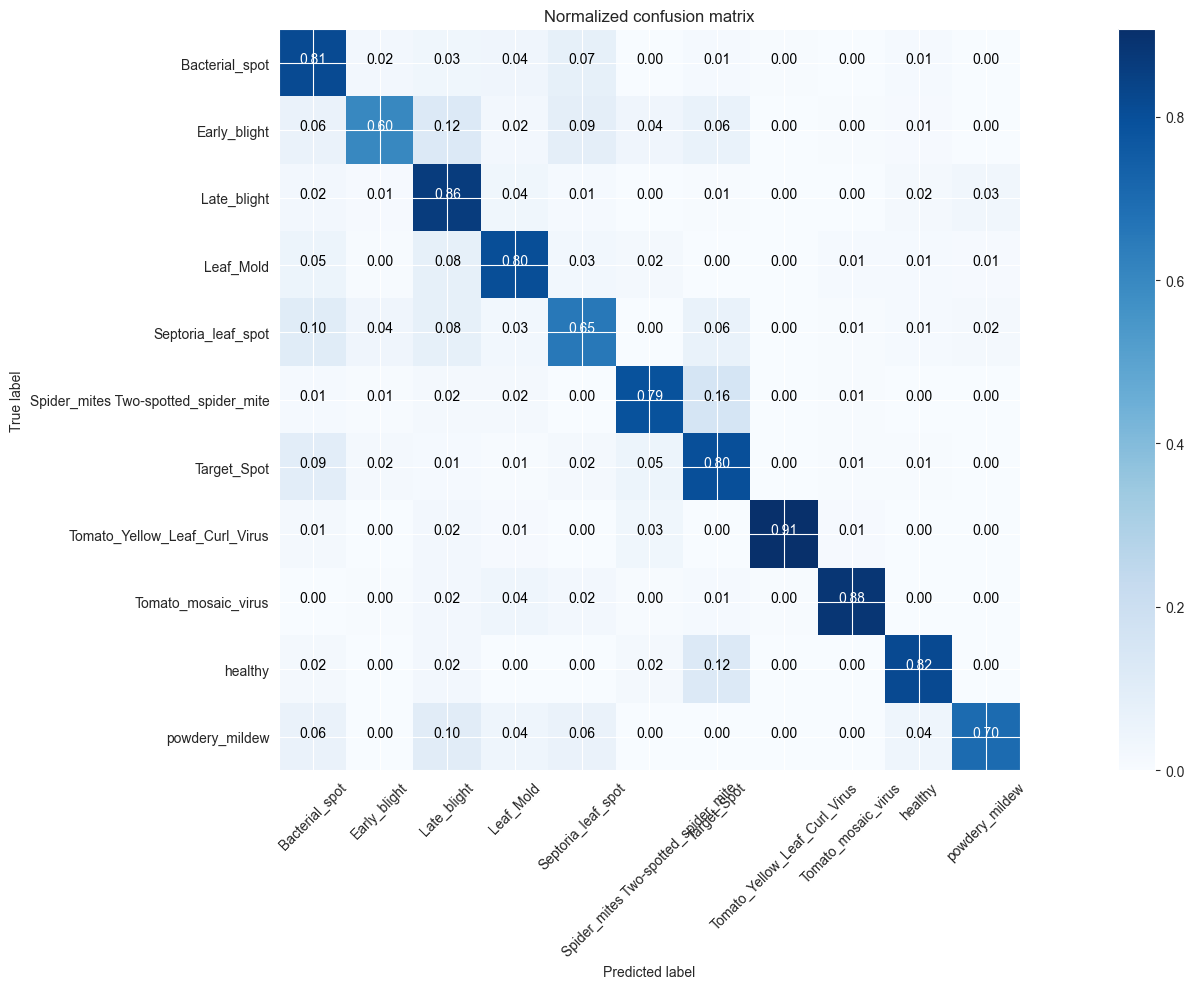

In [20]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, class_names, normalize=True)

In [21]:
def plot_confusion_matrix_per_class(y_true, y_pred, class_names, normalize=False, cmap=plt.cm.Blues):
    for i, class_name in enumerate(class_names):
        # Bikin label biner: 1 jika label == kelas ini, 0 jika bukan
        y_true_binary = [1 if label == i else 0 for label in y_true]
        y_pred_binary = [1 if label == i else 0 for label in y_pred]

        # Confusion matrix binary
        cm = confusion_matrix(y_true_binary, y_pred_binary)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(5, 5))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(f'Confusion Matrix for Class: {class_name}')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Not ' + class_name, class_name], rotation=45)
        plt.yticks(tick_marks, ['Not ' + class_name, class_name])

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for x, y in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(y, x, format(cm[x, y], fmt),
                     horizontalalignment="center",
                     color="white" if cm[x, y] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()


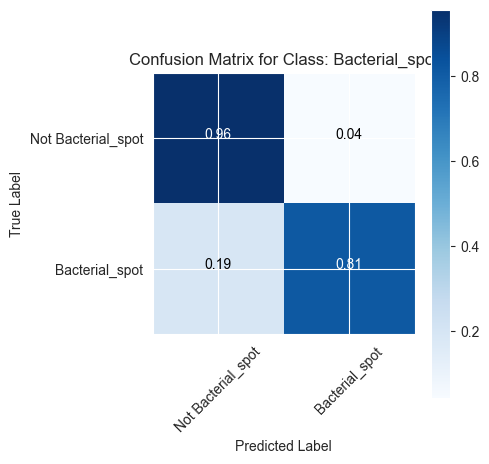

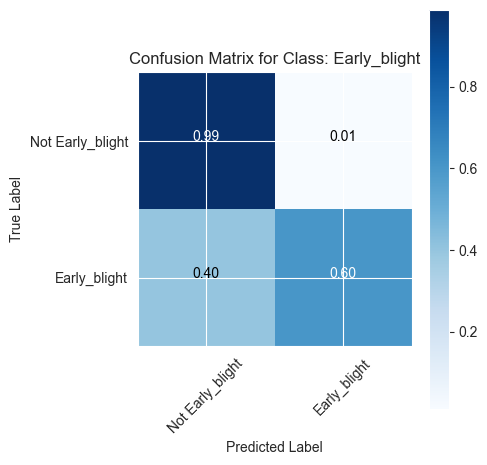

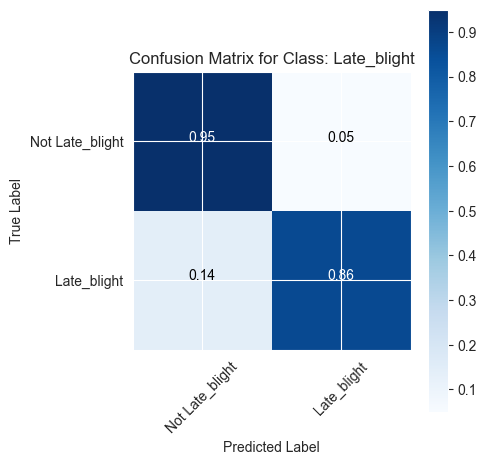

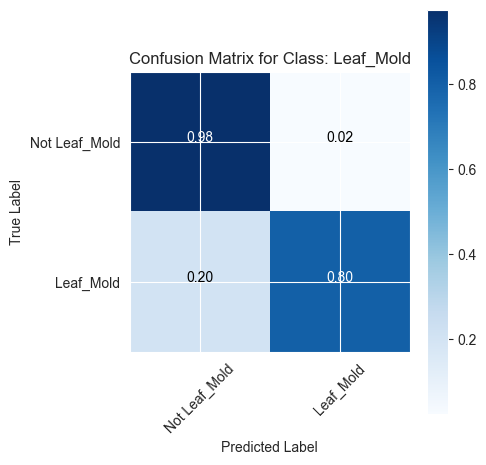

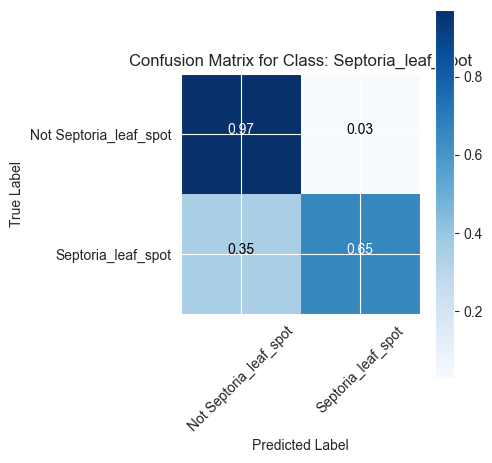

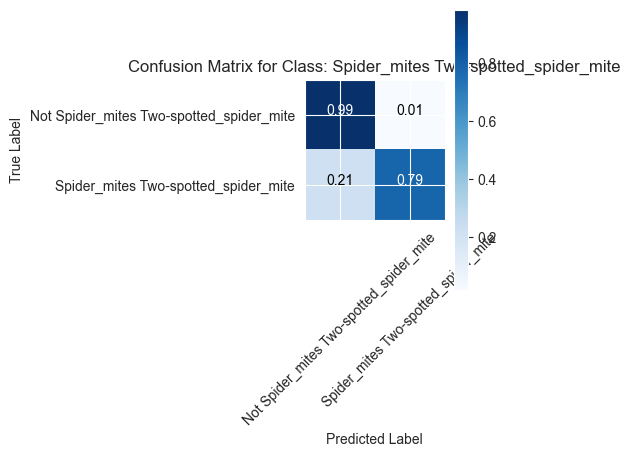

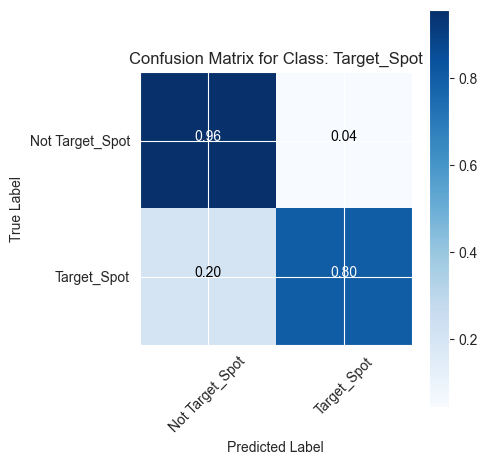

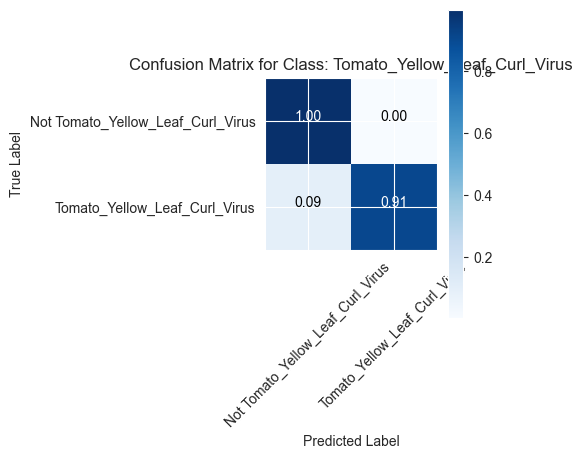

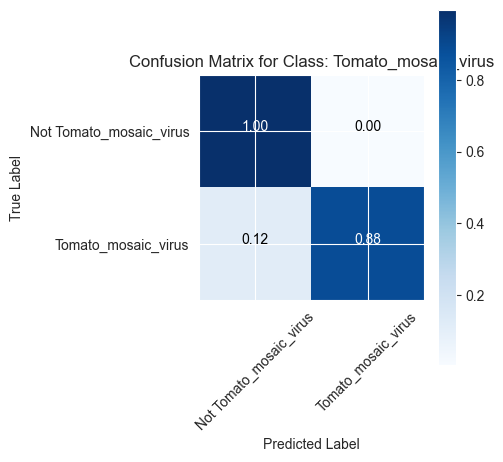

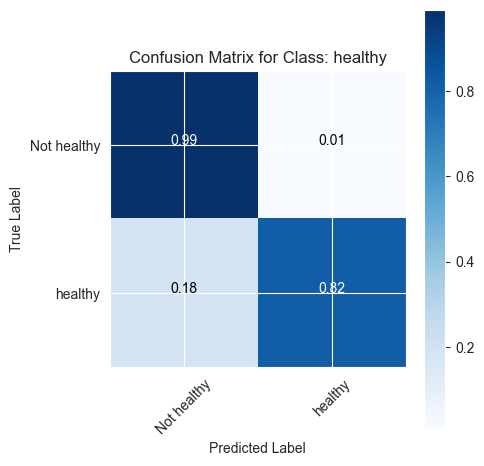

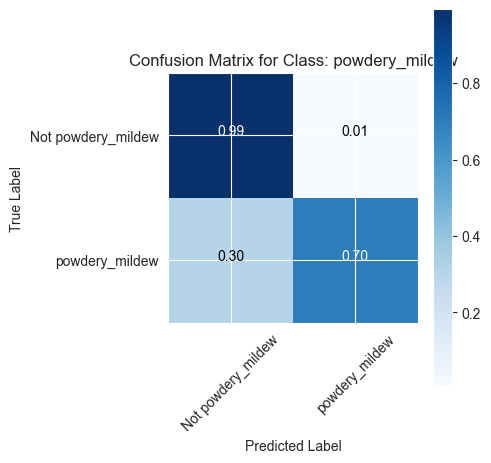

In [22]:
plot_confusion_matrix_per_class(y_true, y_pred_classes, class_names, normalize=True)


In [23]:
model.save('my_model.keras')